<a href="https://colab.research.google.com/github/amtayl25/1d3d/blob/main/1D_dG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install required libraries (try-catch safe)
"""
NOTE: You can save the Docker image state after running this block so that you don't have to run it every time you start a new environment.
"""
import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# ipywidgets
try:
    import ipywidgets
except ImportError:
    !pip install ipywidgets

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# vtk
try:
    import vtk
except ImportError:
    !pip install vtk

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

# meshio
try:
    import meshio
except ImportError:
    !pip install meshio

# pyvista
try:
    import pyvista
except ImportError:
    !pip install pyvista

--2024-11-21 15:11:05--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4164 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.07K  --.-KB/s    in 0s      

2024-11-21 15:11:06 (27.2 MB/s) - ‘/tmp/fenics-install.sh’ saved [4164/4164]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/7b6613c7/releases/pybind11-ins

In [ ]:
# @title Import required modules
import os
WD_PATH = "" # If you're using the default Colab runtime, this is just where the runtime is located
# DATA_FILE_PATH = os.path.join(WD_PATH, "sortedDomain.vtk")

# Libraries
import copy
import datetime
import importlib
import json
import matplotlib.pyplot as plt
import meshio
import networkx as nx
import numpy as np
import scipy
import vtk

from dolfin import *
from graphnics import *
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
from vtk.util.numpy_support import vtk_to_numpy
from xii import *

/usr/local/lib/python3.10/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [ ]:

def adv_diff(grid,degree, T, dt, cn, gamma):

  # Mesh

  mesh = UnitIntervalMesh(grid)

  # Function spaces

  V_dg = FunctionSpace(mesh,"DG",1)
  V_cg = FunctionSpace(mesh,"CG",1)
  V_u  = VectorFunctionSpace(mesh,"CG",1)

  # Veclocity
  u_constant = Constant(1.0)
  u = u_constant
  #u = interpolate(u,V_u)


  cinlet = Constant(10.0)

  # Time step

  for t in np.arange(dt, T+dt, dt):
      # Trial and test functions
      c1 = TrialFunction(V_dg)
      #c3 = TrialFunction(V_dg)
      w  = TestFunction(V_dg)


      # Source term
      c = cn #/dt
      g = Constant(1.0) # c1-c3

      # Penalty term
      alpha = Constant(5.0)

      # Mesh-related functions
      n = FacetNormal(mesh)
      h = CellDiameter(mesh)
      #h_avg = (h('+') + h('-'))/2


      # Upwind
      uv = as_vector((u,))
      un = (dot(uv,n) + abs(dot(uv,n)) )/2.0

      # Define boundary subdomains
      class Left(SubDomain):
        def inside(self, x, on_boundary):
                  return on_boundary and near(x[0], 0)

      class Right(SubDomain):
        def inside(self, x, on_boundary):
                  return on_boundary and near(x[0], 1)

      left = Left()
      right = Right()


      # Mark boundaries
      boundaries = MeshFunction('size_t', mesh,mesh.topology().dim()-1)
      boundaries.set_all(0)
      left.mark(boundaries,0)
      right.mark(boundaries,1)

      dxLambda = Measure('dx', domain = mesh)
      dsLambda = Measure('ds', domain = mesh, subdomain_data = boundaries)
      gamma3 = Constant(1.0)

      # Bilinear form

      a_vol = dot(w,c1/dt)*dxLambda - dot(grad(w),grad(c1)+uv*c1)*dxLambda


      a_fac = - dot(avg(grad(w)), jump(c1, n))*dS \
                  - dot(jump(w, n), avg(grad(c1)))*dS \
                  + (alpha('+')/h('+'))*dot(jump(w, n), jump(c1, n))*dS \
                  + gamma('+')*dot(grad(w('+')),grad(c1('+')))*dS


      a_vel = dot(jump(w), un('+')*c1('+') - un('-')*c1('-'))*dS \
                  + dot(w,un*c1)*dsLambda(1)#+ w*un*c1*dsLambda(1)

      a     = a_vol + a_fac + a_vel

      # Linear form

      L = dot(w,c/dt)*dxLambda + u*cinlet*w*dsLambda(0) + dot(g,w)*dxLambda

      # Solution function

      ch = Function(V_dg)

      solve(a==L, ch)

      plot(ch)

      #v = interpolate(Expression("x[0]", degree = 1), V_dg)

      #print("Values on left = ", v.vector()[ch.vector() == 1].array())

      #print("Values on right   = ", v.vector()[ch.vector() == 2].array())

      print(ch.vector().get_local())

      #  Project solution to a continuous function space.
      cc = project(ch, V = V_cg)

      plot(cc)
  return cc



[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.14094116  0.53185501  0.03445235  0.10181331  0.00817023  0.02528632
  0.03941411 -0.00508563]
[ 0.140941

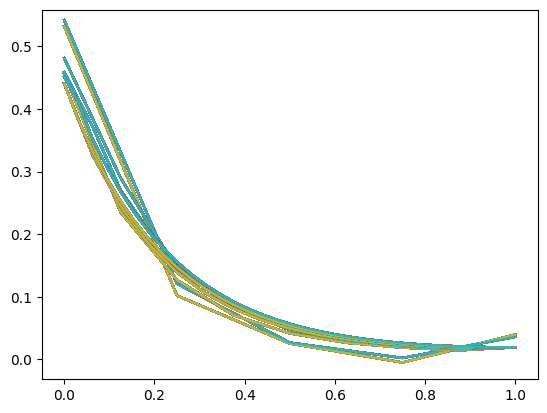

In [ ]:
dt = 0.01
T = 1.0
degree = 1
x = np.linspace(0,1.0,10)
cn = Constant(0.0) #Expression("cos(x)", degree=1)
gamma = Constant(1.0)
ch_constant_4 = adv_diff(4,degree, T, dt, cn, gamma)
ch_constant_8 = adv_diff(8,degree, T, dt, cn, gamma)
ch_constant_16 = adv_diff(16,degree, T, dt, cn, gamma)
ch_constant_32 = adv_diff(32,degree, T, dt, cn, gamma)

mesh = UnitIntervalMesh(50)
zero = Constant(0.0)
V = FunctionSpace(mesh,"CG",1)
zeromesh = interpolate(zero,V)

#Calculate errors
norm_error = errornorm(ch_constant_4, ch_constant_32, 'L2')
norm_4 = errornorm(ch_constant_4, zeromesh, 'L2')
norm = errornorm(ch_constant_32, zeromesh, 'L2')
relative_error_constant_4 =  norm_error/norm
print("The L2 norm of n=4 is", norm_4)
print("The relative error between n=4 and n=32 is", relative_error_constant_4)

norm_error = errornorm(ch_constant_8, ch_constant_32, 'L2')
norm_8 = errornorm(ch_constant_8, zeromesh, 'L2')
norm = errornorm(ch_constant_32, zeromesh, 'L2')
relative_error_constant_8 =  norm_error/norm
print("The L2 norm of n=8 is", norm_8)
print("The relative error between n=8 and n=32 is", relative_error_constant_8)

norm_error = errornorm(ch_constant_16, ch_constant_32, 'L2')
norm_16 = errornorm(ch_constant_16, zeromesh, 'L2')
norm = errornorm(ch_constant_32, zeromesh, 'L2')
relative_error_constant_16 =  norm_error/norm
print("The L2 norm of n=16 is", norm_16)
print("The relative error between n=16 and n=32 is", relative_error_constant_16)


print("Convergence rate of w for n=4 is", np.log(relative_error_constant_4/relative_error_constant_8)/np.log(2))
print("Convergence rate of w for n=8 is", np.log(relative_error_constant_8/relative_error_constant_16)/np.log(2))

    Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:    Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:    Compiling form ffc_form_b89fbd48b501512c4aa5da27a3b8d5680febb2f5
    
INFO:FFC:    Compiler stage 1: Analyzing form(s)
INFO:FFC:    -----------------------------------
DEBUG:FFC:      Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:      
INFO:FFC:      Geometric dimension:                 1
      Number of cell subdomains:           0
      Number of exterior_facet subdomains: 1
      Rank:                                1
      Arguments:                           '(v_0)'
      Number of coefficients:              3
      Coefficients:                        '[f_65414, f_65415, f_65416]'
      Unique elements:                     'DG1(?,?), R0(?,?), Vector<1 x CG1(?,?)>'
      Unique sub element

[0.56961258 0.56976459 0.56795045 0.56807364 0.56643004 0.5665426
 0.56504069 0.56514354 0.56377111 0.56386509 0.56261098 0.56269687
 0.56155088 0.56162936 0.5605822  0.56065391 0.55969705 0.55976258
 0.55888825 0.55894812 0.55814923 0.55820394 0.55747398 0.55752396
 0.55685701 0.55690268 0.55629331 0.55633504 0.55577831 0.55581643
 0.5553078  0.55534263 0.55487799 0.5549098  0.55448536 0.55451442
 0.55412673 0.55415327 0.55379919 0.55382343 0.55350008 0.55352221
 0.55322696 0.55324717 0.55297762 0.55299607 0.55275003 0.55276687
 0.55254235 0.55255771 0.55235289 0.5523669  0.55218011 0.55219288
 0.5520226  0.55203425 0.5518791  0.5518897  0.55174843 0.55175808
 0.55162953 0.55163831 0.55152145 0.55152943 0.55142331 0.55143055
 0.5513343  0.55134087 0.55125372 0.55125966 0.55118091 0.55118627
 0.55111528 0.55112011 0.55105631 0.55106064 0.55100351 0.55100738
 0.55095647 0.55095991 0.55091481 0.55091784 0.5508782  0.55088085
 0.55084634 0.55084863 0.55081898 0.55082094 0.55079591 0.55079

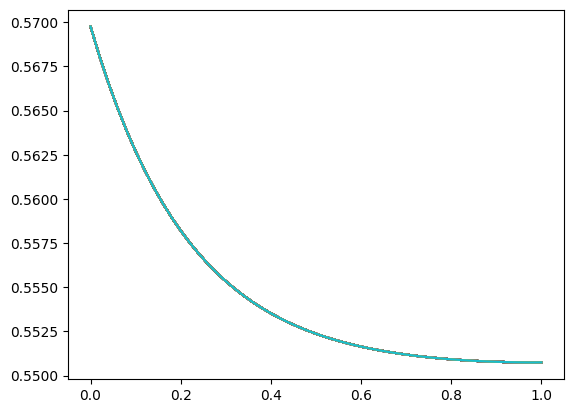

In [ ]:
grid = 50
dt = 0.01
T = 1.0
degree = 1
x = 1
cn = cos(x)
gamma = Constant(1.0)
ch_cos = adv_diff(grid,degree, T, dt, cn, gamma)

In [ ]:
mesh = UnitIntervalMesh(50)
zero = Constant(0.0)
V = FunctionSpace(mesh,"CG",1)
zeromesh = interpolate(zero,V)

#Calculate errors
norm_constant = errornorm(ch_constant, zeromesh, 'L2')
print("The error of constant concentration is", norm_constant)

norm_linear = errornorm(ch_linear, zeromesh, 'L2')
print("The error of x+1 concentration is", norm_linear)

norm_power2 = errornorm(ch_power2, zeromesh, 'L2')
print("The error of x^2+1 concentration is", norm_power2)

norm_lineartime = errornorm(ch_linear, zeromesh, 'L2')
print("The error of t+x+1 concentration is", norm_lineartime)

norm_cosx = errornorm(ch_cos, zeromesh, 'L2')
print("The error of cos(x) concentration is", norm_cosx)

norm_tcosx = errornorm(ch_tcos, zeromesh, 'L2')
print("The error of tcos(x) concentration is", norm_tcosx)


The error of constant concentration is 0.02286259781622622
The error of x+1 concentration is 1.009899500427495
The error of x^2+1 concentration is 0.02286259781622622
The error of t+x+1 concentration is 1.009899500427495
The error of cos(x) concentration is 0.5548452173600529
The error of tcos(x) concentration is 0.5548452173600529
